# DIFFERENTIAL GENE EXPRESSION ANALYSIS

# Python packages

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import pertpy 
import rpy2.robjects as robjects
import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
from modules.deg_analysis import *

# R packages

In [ ]:
sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

# Load dataset

In [2]:
adata = sc.read(
    filename="data/fede_count_clustered.h5ad"
)

In [3]:
adata = adata[adata.obs['Sample_Tag'] != "Undetermined", :]

# Differential gene expression analysis - Sample level

In [4]:
cell_types = adata.obs["subclass_name"].cat.categories
adata_pb = aggregate_and_filter(adata, 
                                cell_types[0], 
                                condition_key="Sample_Tag", 
                                cell_identity_key="subclass_name", 
                                obs_to_keep=['Sample_Tag', 'subclass_name'])

for i, cell_type in enumerate(cell_types[1:], start=2):
    adata_cell_type = aggregate_and_filter(adata, 
                                           cell_type, 
                                           condition_key="Sample_Tag", 
                                           cell_identity_key="subclass_name", 
                                           obs_to_keep=['Sample_Tag', 'subclass_name'])
    adata_pb = adata_pb.concatenate(adata_cell_type)

adata_pb.layers['counts'] = adata_pb.X.copy()

### Pseudo-replicates PCA

In [6]:
sc.pp.normalize_total(adata_pb, target_sum=1e6)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)

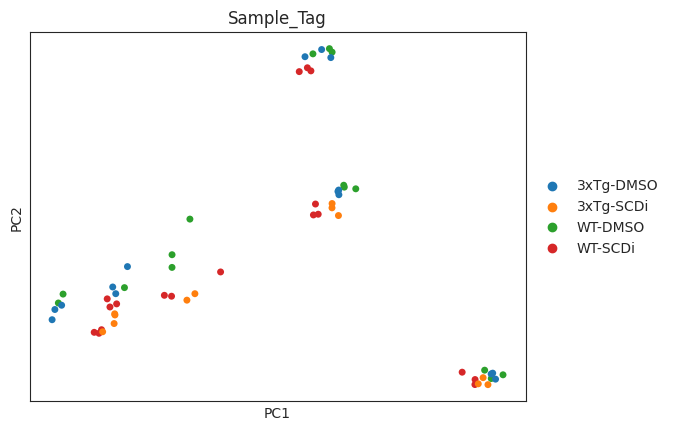

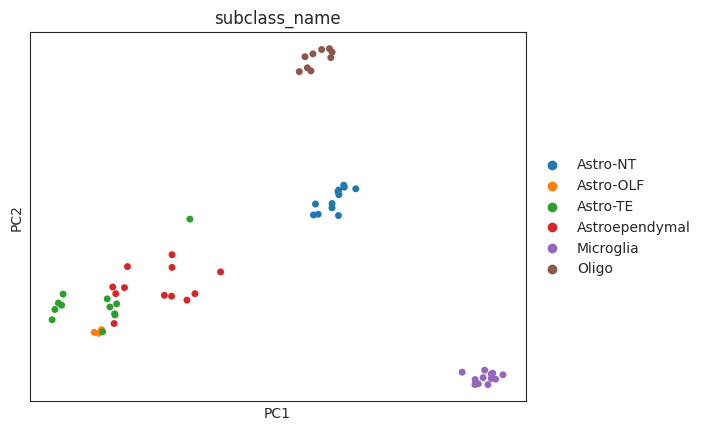

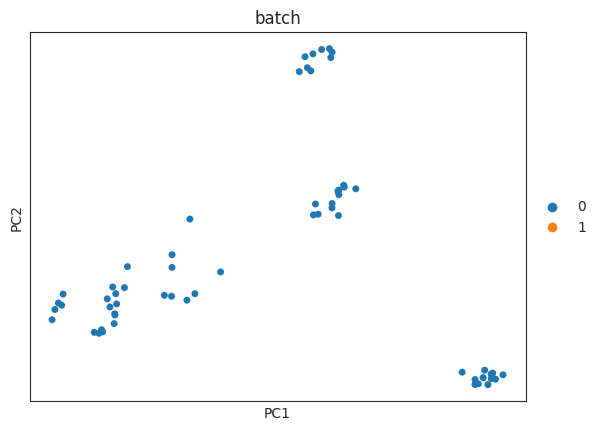

In [8]:
sc.settings.figdir = 'figures/pca_plot_'
color_vars = adata_pb.obs.columns
for var in color_vars:
    sc.pl.pca(adata_pb, color=var, ncols=1, size=100, save=f'pca_plot_{var}.png')

### Create control and condition anndata objects

In [241]:
ctr_name = 'Astrocytes WT-DMSO'
cnd_name = 'Astrocytes WT-SCDi'

In [242]:
adata_pb.X = adata_pb.layers['counts'].copy()
adata_pb.X = adata_pb.X.astype(np.float32)

In [243]:
ctr_sample_tags = list(set(adata.obs['Sample_Tag'].values))
ctr_sample_tags = ['WT-DMSO']

cnd_sample_tags = list(set(adata.obs['Sample_Tag'].values))
cnd_sample_tags = ['WT-SCDi']

In [244]:
# control_df = adata_pb[
#     (adata_pb.obs['Sample_Tag'].isin(ctr_sample_tags)) &
#     (adata_pb.obs['cluster_subclass_name'] != 'Astro-NT_2') &
#     (adata_pb.obs['cluster_subclass_name'].str.startswith('Astro-NT'))
# ].to_df()

In [245]:
# condition_df = adata_pb[(adata_pb.obs['Sample_Tag'].isin(cnd_sample_tags)) & (adata_pb.obs['cluster_subclass_name'] == 'Astro-NT_2')].to_df()

In [246]:
control_df = adata_pb[(adata_pb.obs['Sample_Tag'].isin(ctr_sample_tags)) & (adata_pb.obs['subclass_name'].str.startswith('Astro-NT'))].to_df()

In [247]:
condition_df = adata_pb[(adata_pb.obs['Sample_Tag'].isin(cnd_sample_tags)) & (adata_pb.obs['subclass_name'].str.startswith('Astro-NT'))].to_df()

In [248]:
results_df = deseq2_dea(control_df, condition_df, save_path=None)

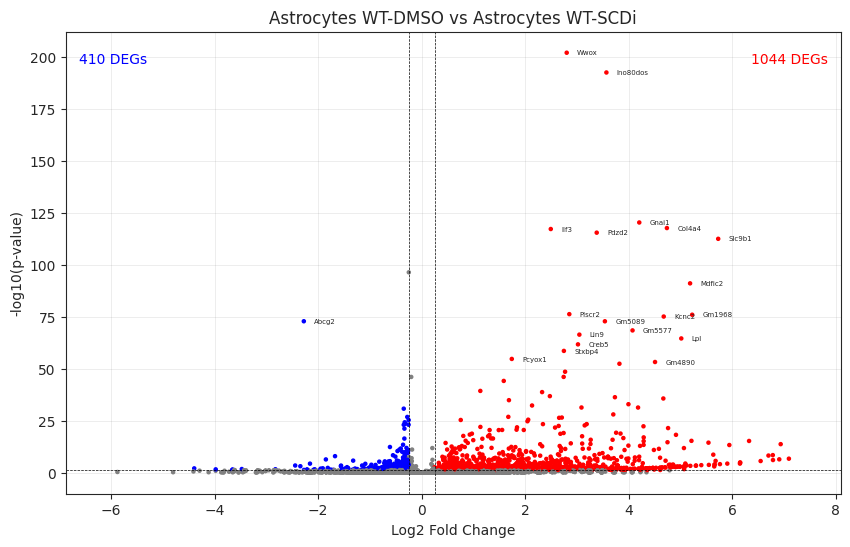

In [249]:
volcano_plot(results_df,
             min_fold_change=0.25,
             max_p_value=0.05,
             fig_title=f'{ctr_name} vs {cnd_name}',
             save_path=f'figures/{ctr_name}_{cnd_name}_volcano_plot.png')

In [250]:
ranked_genes = results_df.sort_values(by='padj')

In [251]:
ranked_genes.head(10)

,names,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
10626,Iqcb1,624.921701,4.256706,0.106896,39.820966,0.000000e+00,0.000000e+00
6401,Fnbp1l,1009.978889,4.181893,0.082148,50.906922,0.000000e+00,0.000000e+00
14511,Ppt1,850.254898,3.655587,0.076384,47.857945,0.000000e+00,0.000000e+00
14485,Ppp2r3a,2344.968665,4.134635,0.089152,46.377384,0.000000e+00,0.000000e+00
2769,Cadps2,11014.109062,5.589989,0.056050,99.732085,0.000000e+00,0.000000e+00
5743,Eno1b,831.133316,4.147769,0.096228,43.103620,0.000000e+00,0.000000e+00
19243,Wwox,440.152349,2.800996,0.091428,30.636218,4.033242e-206,9.495980e-203
10569,Ino80dos,330.684680,3.568073,0.119296,29.909459,1.482495e-196,3.054125e-193
9582,Gnai1,220.069041,4.203028,0.177209,23.717945,2.354450e-124,4.311521e-121
3817,Col4a4,237.266018,4.736942,0.201975,23.453170,1.227024e-121,2.022258e-118


# Differential gene expression analysis - Cell level

### Create control and condition anndata objects

In [252]:
ctr_name = 'Astrocytes WT-DMSO'
cnd_name = 'Astrocytes WT-SCDi'

In [253]:
adata.X = adata.layers['counts']
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

In [254]:
ctr_sample_tags = list(set(adata.obs['Sample_Tag'].values))
ctr_sample_tags = ['WT-DMSO']

cnd_sample_tags = list(set(adata.obs['Sample_Tag'].values))
cnd_sample_tags = ['WT-SCDi']

In [255]:
# control_df = adata[
#     (adata.obs['Sample_Tag'].isin(ctr_sample_tags)) &
#     (adata.obs['cluster_subclass_name'] != 'Astro-NT_4') &
#     (adata.obs['cluster_subclass_name'].str.startswith('Astro-NT'))
# ].to_df()

# condition_df = adata[(adata.obs['Sample_Tag'].isin(cnd_sample_tags)) & (adata.obs['cluster_subclass_name'] == 'Astro-NT_4')].to_df()

In [256]:
control_df = adata[(adata.obs['Sample_Tag'].isin(ctr_sample_tags)) & (adata.obs['subclass_name'].str.startswith('Astro-NT'))].to_df()

In [257]:
condition_df = adata[(adata.obs['Sample_Tag'].isin(cnd_sample_tags)) & (adata.obs['subclass_name'].str.startswith('Astro-NT'))].to_df()

In [258]:
results_df = mast_dea(adata, control_df, condition_df, save_path=None)

[1] "Shape of exprs_data: 25244 x 2378"
[1] "Shape of cdata: 2378 x 1"
[1] "Shape of fdata: 25244 x 1"


### Visualization - Volcano plot

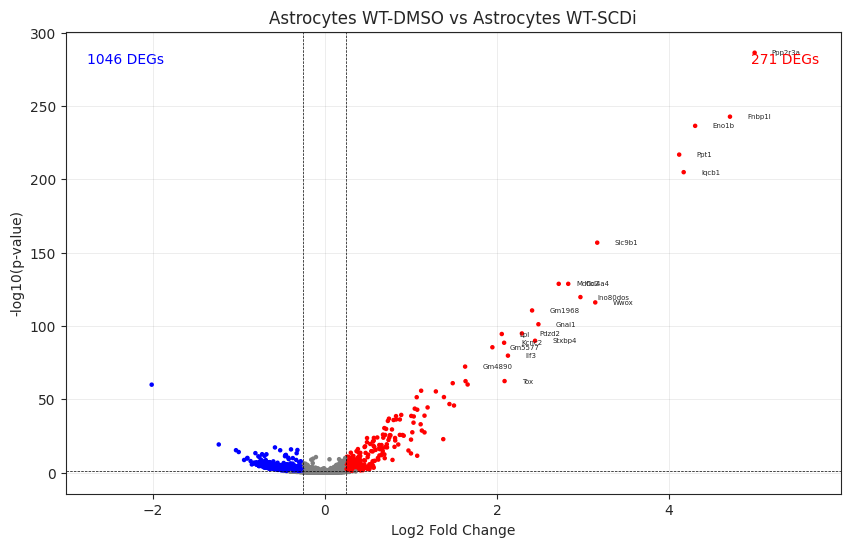

In [259]:
volcano_plot(results_df,
             min_fold_change=0.25,
             max_p_value=0.05,
             fig_title=f'{ctr_name} vs {cnd_name}',
             save_path=f'figures/{ctr_name}_{cnd_name}_volcano_plot.png')

In [260]:
ranked_genes = results_df.sort_values(by='padj')

In [261]:
ranked_genes.head(10)

,names,Pr(>Chisq),log2FoldChange,padj
3485,Cadps2,0.000000e+00,5.286432,0.000000e+00
19068,Ppp2r3a,4.404151e-291,4.996036,5.558920e-287
8013,Fnbp1l,2.514334e-247,4.709432,2.115728e-243
7267,Eno1b,6.152678e-241,4.304619,3.882955e-237
19094,Ppt1,3.031144e-221,4.119011,1.530364e-217
14599,Iqcb1,3.435005e-209,4.171264,1.445221e-205
21459,Slc9b1,4.375951e-161,3.166296,1.578093e-157
15979,Mdfic2,6.409190e-133,2.718708,1.797707e-129
4711,Col4a4,6.007578e-133,2.829275,1.797707e-129
14538,Ino80dos,7.865233e-124,2.971098,1.985499e-120


# Gene set and pathway enrichment analysis

In [262]:
UP_genes_name, DOWN_genes_name = get_DEGs(results_df,
                                          max_pval=0.05,
                                          min_fold_change=0.25)

In [263]:
UP_GO = go_enrichment_analysis(UP_genes_name, save_path=None)
DOWN_GO = go_enrichment_analysis(DOWN_genes_name, save_path=None)

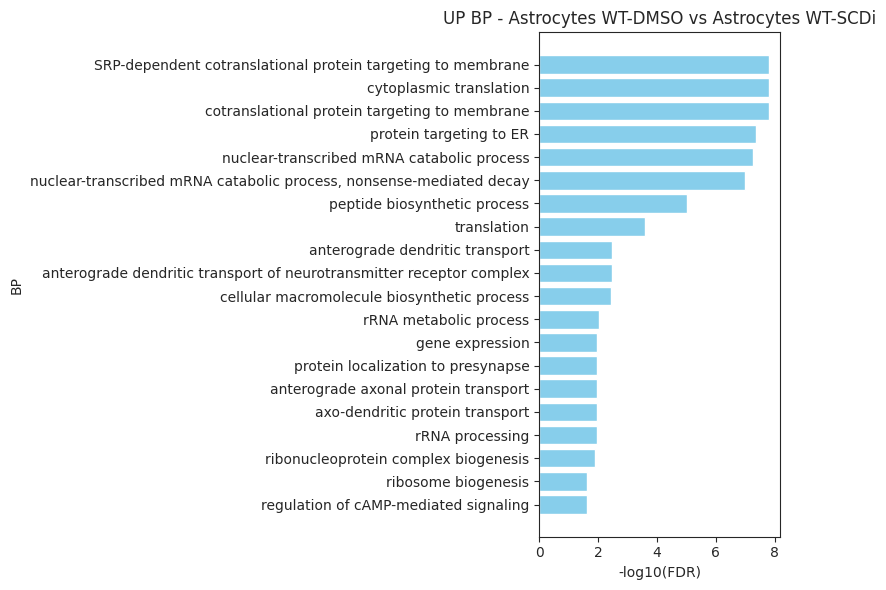

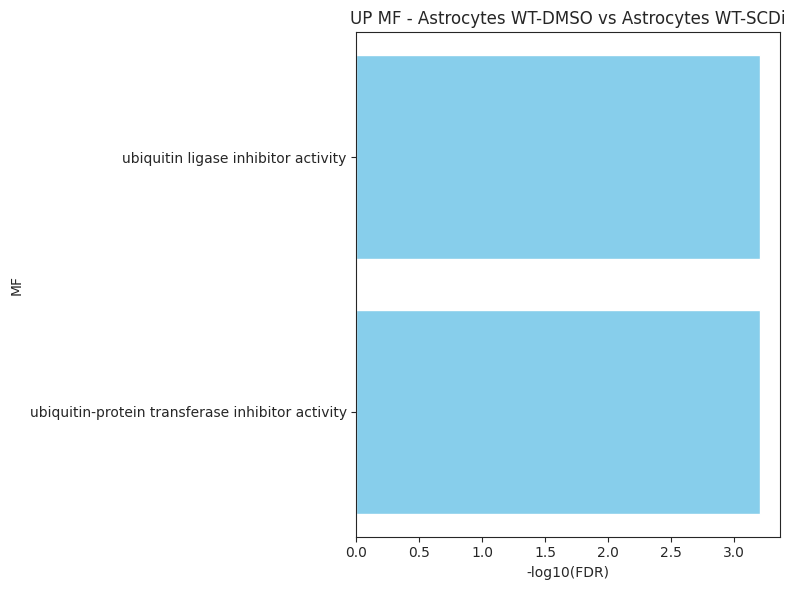

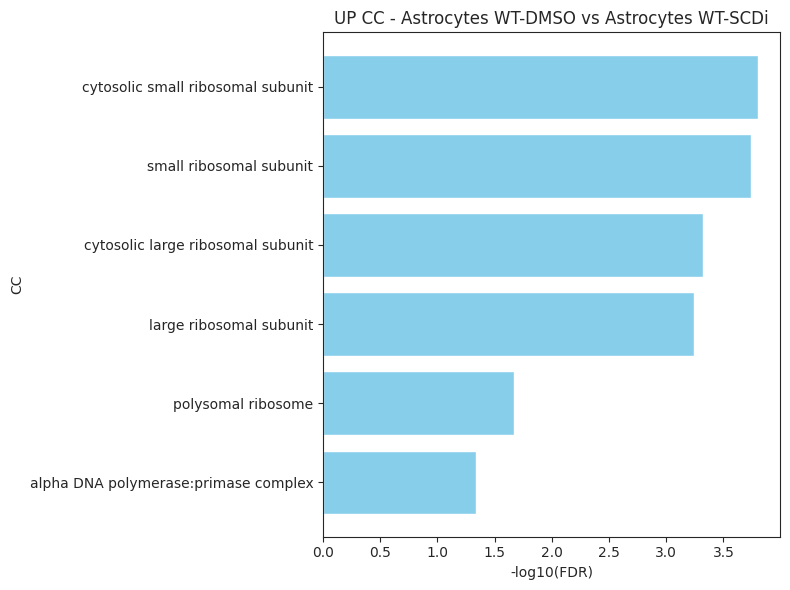

In [264]:
display_go_enrichment(UP_GO,
                      namespace='BP',
                      fig_title=f'UP BP - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_UP_BP')

display_go_enrichment(UP_GO, 
                      namespace='MF',
                      fig_title=f'UP MF - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_UP_MF')

display_go_enrichment(UP_GO, 
                      namespace='CC',
                      fig_title=f'UP CC - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_UP_CC')

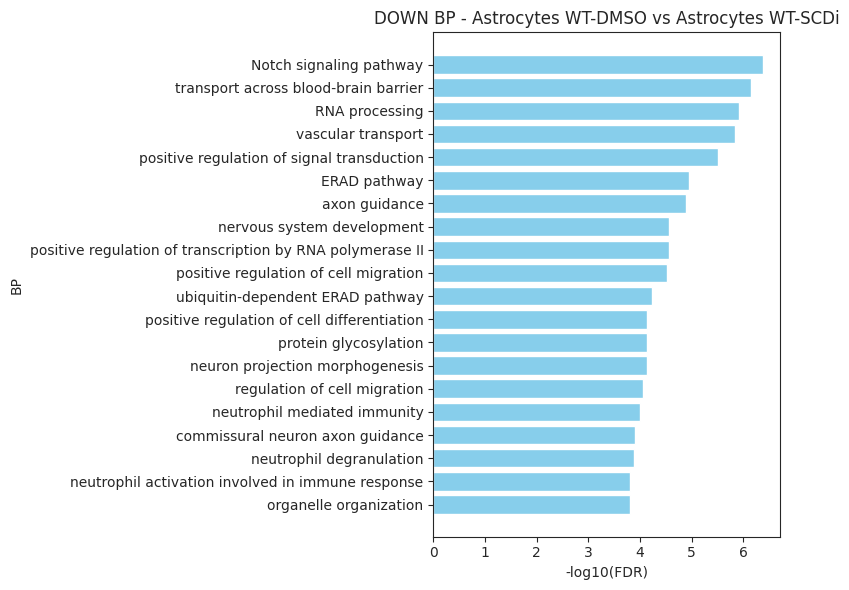

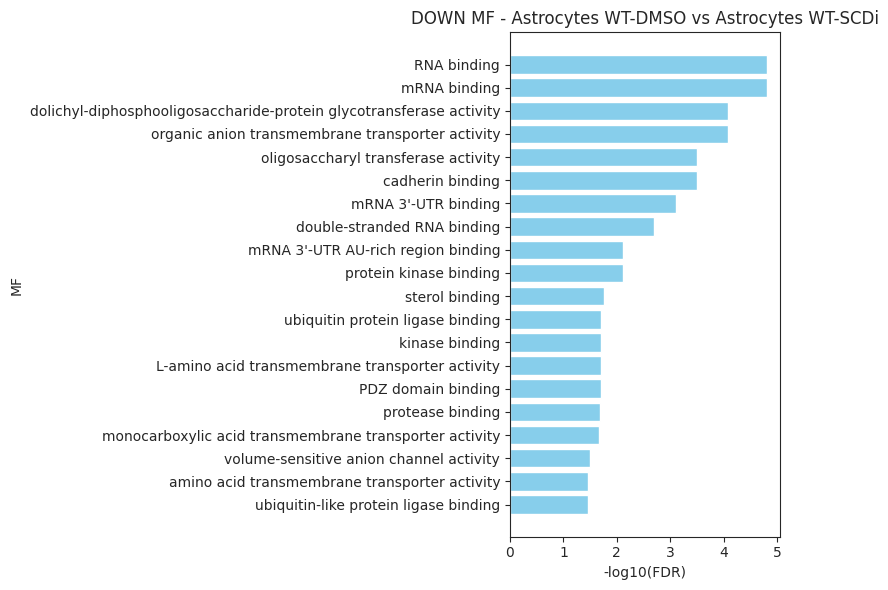

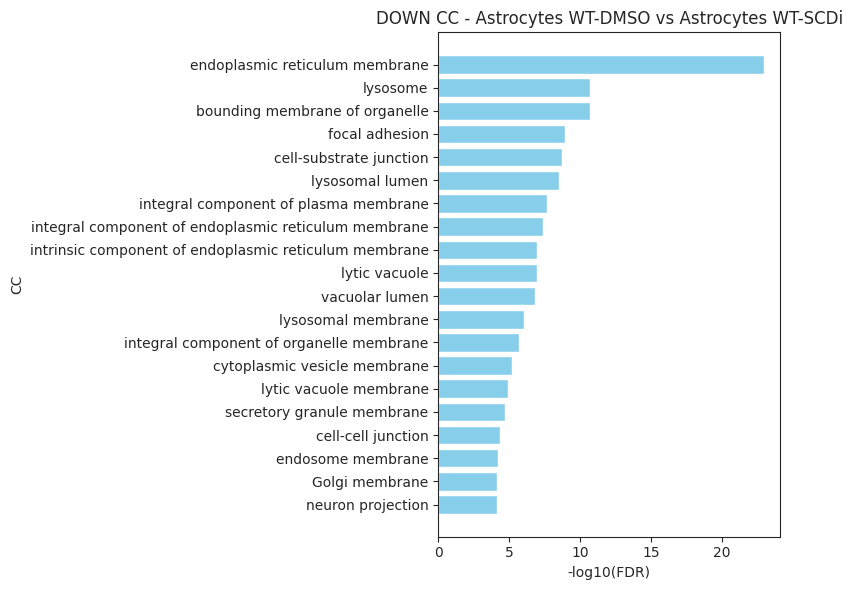

In [265]:
display_go_enrichment(DOWN_GO, 
                      namespace='BP',
                      fig_title=f'DOWN BP - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_DOWN_BP')

display_go_enrichment(DOWN_GO, 
                      namespace='MF',
                      fig_title=f'DOWN MF - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_DOWN_MF')

display_go_enrichment(DOWN_GO, 
                      namespace='CC',
                      fig_title=f'DOWN CC - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_DOWN_CC')

In [266]:
UP_KEGG = kegg_enrichment_analysis(UP_genes_name, 
                                   save_path=None)

In [267]:
DOWN_KEGG = kegg_enrichment_analysis(DOWN_genes_name, 
                                     save_path=None)

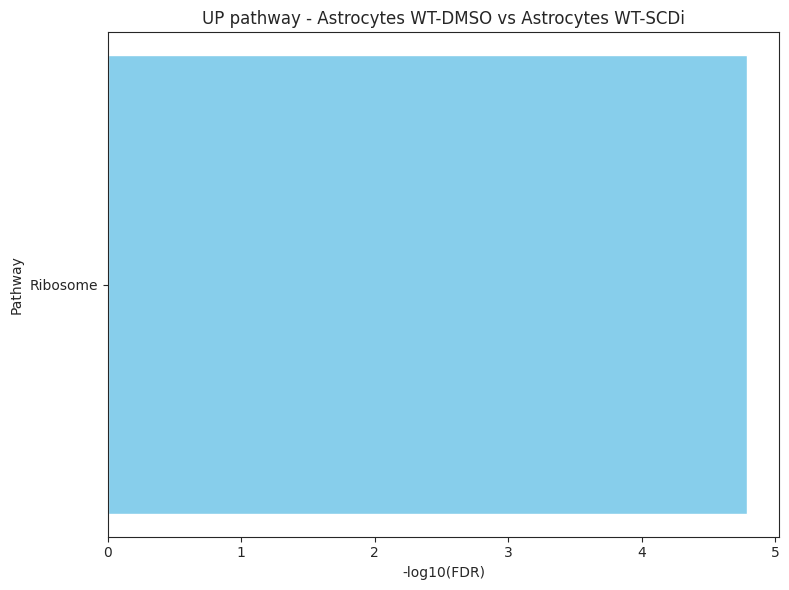

In [268]:
display_kegg_enrichment(UP_KEGG,
                        fig_title=f'UP pathway - {ctr_name} vs {cnd_name}',
                        save_path=f'figures/{ctr_name}_{cnd_name}_display_KEGG_enrichment_UP')

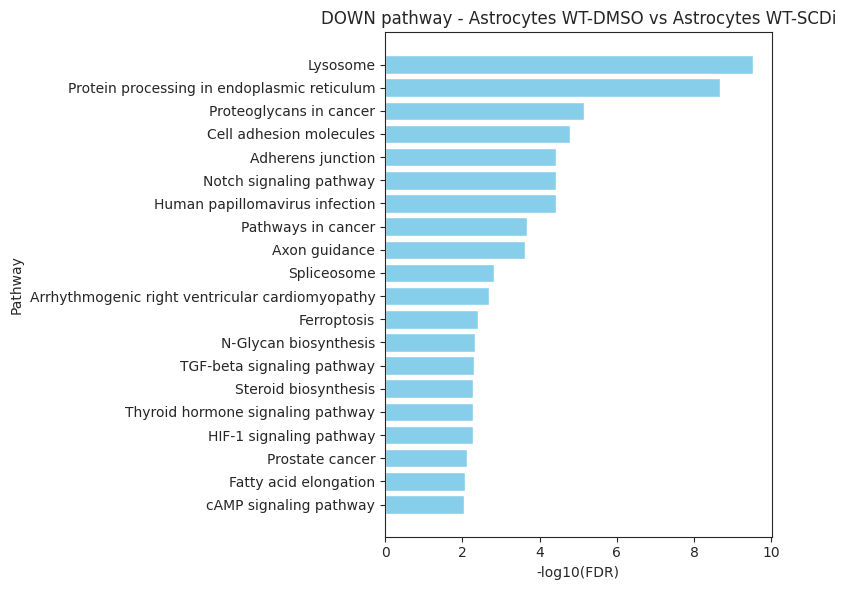

In [269]:
display_kegg_enrichment(DOWN_KEGG,
                        fig_title=f'DOWN pathway - {ctr_name} vs {cnd_name}',
                        save_path=f'figures/{ctr_name}_{cnd_name}_display_KEGG_enrichment_DOWN')